Import Libraries 

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from numpy.random import seed
!pip install shap 
import shap


Set Up

In [33]:
#adjust colab settings to not cut off columns and rows in print settings 
pd.options.display.max_columns = None
pd.options.display.max_rows = None

seed(1)#to reproduce same results

Mount Google Drive

In [34]:
#mounting google drive
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully!")
    %tensorflow_version 2.x
except Exception as e:
    print("Error while mounting Google Drive: {}".format(str(e)))

Mounted at /content/drive
Google Drive mounted successfully!


In [35]:
#importing the data set from drive
DATA_PATH = '/content/drive/My Drive/Kanmani_folder/modeldata.csv'
df = pd.read_csv(DATA_PATH)

Global Variables 

In [36]:
cutoff = 0.5 #Success rate cutoff for categorized as Success 

Helper Functions

In [37]:
#true and false ---> 1 and 0
def tf(x):
  if x == 't':
    x = 1
  else: 
    x = 0
  return x

Preview of Uncleaned Data

In [38]:
df.head(2)

,Unnamed: 0,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_years,Success_rate,mean_price,host_in_sfo,licensed,top_amenities_count,host_verification_count
0,0,0,100,98,t,1.0,t,t,Group1,Entire serviced apartment,Entire home/apt,3,bath group1,1.0,2.0,2,30,2.0,2.0,1125.0,1125.0,2.0,1125.0,315,42,0,4.87,4.95,4.95,4.90,4.98,f,1,1,0,0,2.08,13.4,0.71303,172.2,1.0,0.0,3,5
1,1,2,100,71,f,2.0,t,t,Group1,Entire rental unit,Entire home/apt,5,bath group1,2.0,3.0,30,60,30.0,30.0,60.0,60.0,30.0,60.0,111,0,0,4.88,4.87,4.89,4.85,4.77,f,1,1,0,0,0.72,12.9,0.00000,235.0,0.0,0.0,2,5


Clean Data

In [39]:
df = df.drop(columns=['Unnamed: 0'])
df = df.rename(columns={"bathrooms_text": "bathroom_group"})

In [40]:
#true and false ---> 1 and 0
df['host_is_superhost'] = df['host_is_superhost'].apply(tf)
df['host_has_profile_pic'] = df['host_has_profile_pic'].apply(tf)
df['host_identity_verified'] = df['host_identity_verified'].apply(tf)
df['instant_bookable'] = df['instant_bookable'].apply(tf)


In [41]:
#create dummies for categorical variables (bathroom group, property_type, room_type)
df = pd.get_dummies(df)

In [42]:
#Create Classification for Success based on cutoff 
df['Success'] = 0
df.loc[df['Success_rate'] >= cutoff, 'Success'] = 1

Display Data 

In [43]:
df.head(5)

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,accommodates,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_years,Success_rate,mean_price,host_in_sfo,licensed,top_amenities_count,host_verification_count,neighbourhood_cleansed_Group1,neighbourhood_cleansed_Group2,property_type_Entire condominium (condo),property_type_Entire guest suite,property_type_Entire loft,property_type_Entire rental unit,property_type_Entire residential home,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Private room in condominium (condo),property_type_Private room in guest suite,property_type_Private room in rental unit,property_type_Private room in residential home,property_type_Room in aparthotel,property_type_Room in boutique hotel,property_type_Room in hotel,property_type_Shared room in hostel,property_type_other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bathroom_group_bath group1,bathroom_group_bath group2,bathroom_group_bath group3,bathroom_group_bath group4,bathroom_group_bath group5,bedrooms_1.0,bedrooms_2.0,bedrooms_3.0,bedrooms_More than 3,Success
0,0,100,98,1,1.0,1,1,3,2.0,2,30,2.0,2.0,1125.0,1125.0,2.0,1125.0,315,42,0,4.87,4.95,4.95,4.90,4.98,0,1,1,0,0,2.08,13.4,0.71303,172.2,1.0,0.0,3,5,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1
1,2,100,71,0,2.0,1,1,5,3.0,30,60,30.0,30.0,60.0,60.0,30.0,60.0,111,0,0,4.88,4.87,4.89,4.85,4.77,0,1,1,0,0,0.72,12.9,0.00000,235.0,0.0,0.0,2,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2,0,100,100,0,10.0,1,1,2,1.0,32,60,32.0,32.0,60.0,60.0,32.0,60.0,19,0,0,4.20,3.87,4.67,4.60,4.73,0,9,0,9,0,0.13,12.6,0.00000,62.1,1.0,0.0,1,5,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
3,0,100,100,0,10.0,1,1,2,1.0,32,90,32.0,32.0,90.0,90.0,32.0,90.0,8,0,0,4.63,4.38,4.75,4.75,4.63,0,9,0,9,0,0.09,12.6,0.00000,62.1,1.0,0.0,1,5,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
4,1,94,0,0,2.0,1,1,4,2.0,7,111,7.0,7.0,111.0,111.0,7.0,111.0,28,0,0,4.87,5.00,4.94,5.00,4.94,0,2,2,0,0,0.19,12.5,0.00000,895.0,1.0,1.0,2,4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


In [44]:
df.describe()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,accommodates,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_years,Success_rate,mean_price,host_in_sfo,licensed,top_amenities_count,host_verification_count,neighbourhood_cleansed_Group1,neighbourhood_cleansed_Group2,property_type_Entire condominium (condo),property_type_Entire guest suite,property_type_Entire loft,property_type_Entire rental unit,property_type_Entire residential home,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Private room in condominium (condo),property_type_Private room in guest suite,property_type_Private room in rental unit,property_type_Private room in residential home,property_type_Room in aparthotel,property_type_Room in boutique hotel,property_type_Room in hotel,property_type_Shared room in hostel,property_type_other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bathroom_group_bath group1,bathroom_group_bath group2,bathroom_group_bath group3,bathroom_group_bath group4,bathroom_group_bath group5,bedrooms_1.0,bedrooms_2.0,bedrooms_3.0,bedrooms_More than 3,Success
count,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6.340000e+03,6340.000000,6.340000e+03,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.00000,6340.00000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000
mean,0.527918,94.601735,84.083281,0.437382,90.580757,0.989274,0.850631,3.100315,1.773975,23.788644,496.388644,25.226183,42.727287,693.427445,7.452534e+06,42.014085,7.429171e+06,46.049842,7.565300,0.629968,3.806366,3.808536,3.900577,3.883219,3.840700,0.353312,15.506151,11.353155,3.565300,0.413722,1.033030,6.674101,0.516751,288.184338,0.688170,0.283123,2.536909,5.416562,0.90836,0.09164,0.098423,0.069401,0.009779,0.294006,0.114826,0.023975,0.008044,0.023344,0.008517,0.075237,0.121924,0.008202,0.058044,0.025552,0.008517,0.052208,0.641009,0.009464,0.329338,0.020189,0.692429,0.135489,0.060568,0.110568,0.000946,0.706309,0.183912,0.078864,0.030915,0.483123
std,0.796353,14.558320,22.325172,0.496103,402.810719,0.103015,0.356480,1.833424,1.202688,50.357233,542.333561,60.263836,124.424256,548.431401,1.262920e+08,121.303554,1.258966e+08,86.870412,18.061262,1.791723,1.940226,1.942162,1.974237,1.970628,1.952748,0.478036,35.331930,34.747266,9.701134,2.890542,1.926405,2.888802,0.350664,800.923418,0.463277,0.450551,1.251367,2.163124,0.28854,0.28854,0.297909,0.254154,0.098413,0.455631,0.318838,0.152983,0.089335,0.151005,0.091903,0.263794,0.327224,0.090199,0.233845,0.157807,0.091903,0.222464,0.479742,0.096828,0.470010,0.140658,0.461524,0.342272,0.238555,0.313621,0.030751,0.455488,0.387443,0.269548,0.173101,0.499755
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000

Features for Model

In [45]:
#list of all variables 
all_features = list(df)

Baseline Accuracy

In [46]:
#obtain the value of successes and not 
counts = df["Success"].value_counts()
print(counts)
num_not = counts[0]
num_successes = counts[1]

0    3277
1    3063
Name: Success, dtype: int64


In [47]:
# determine the bigger class 
if num_not > num_successes: 
  num = num_not
  denom = num_not + num_successes
else: 
  num = num_successes
  denom = num_not + num_successes
  
#determine the baseline accuracy
baseline = num / denom
print("Baseline Model Accuracy:",baseline)

Baseline Model Accuracy: 0.5168769716088328


Traning and Vallidation Data Set Up

In [48]:
#ALL Features
#split dataset in features and target variable
all_X = df[all_features] # Features
all_X = all_X.drop(columns=['Success_rate']) #drop the highly correlated target variable
all_X = all_X.drop(columns=['Success']) #drop the target variable
all_y = df.Success # Target variable
all_X_train, all_X_test, all_y_train, all_y_test = train_test_split(all_X, all_y, test_size=0.2, shuffle=True) # 80% training and 20% test

In [49]:
all_y_str = all_y.astype(str)

In [50]:
all_X_train.shape

(5072, 68)

Models

Basic Decision Tree Classifier

In [51]:
#All Features Model
# Create Decision Tree classifer object
all_clf = DecisionTreeClassifier(max_depth=5,max_features='auto', random_state = 1)
# Train Decision Tree Classifer for all features 
all_clf = all_clf.fit(all_X_train,all_y_train)
#Predict the response for test dataset
all_y_pred = all_clf.predict(all_X_test)
# Model Accuracy
print("All Model Accuracy:",metrics.accuracy_score(all_y_test, all_y_pred))

All Model Accuracy: 0.6246056782334385


Confusion Matrix

In [52]:
print(confusion_matrix(all_y_test, all_y_pred))
print(classification_report(all_y_test, all_y_pred))

[[282 344]
 [132 510]]
              precision    recall  f1-score   support

           0       0.68      0.45      0.54       626
           1       0.60      0.79      0.68       642

    accuracy                           0.62      1268
   macro avg       0.64      0.62      0.61      1268
weighted avg       0.64      0.62      0.61      1268



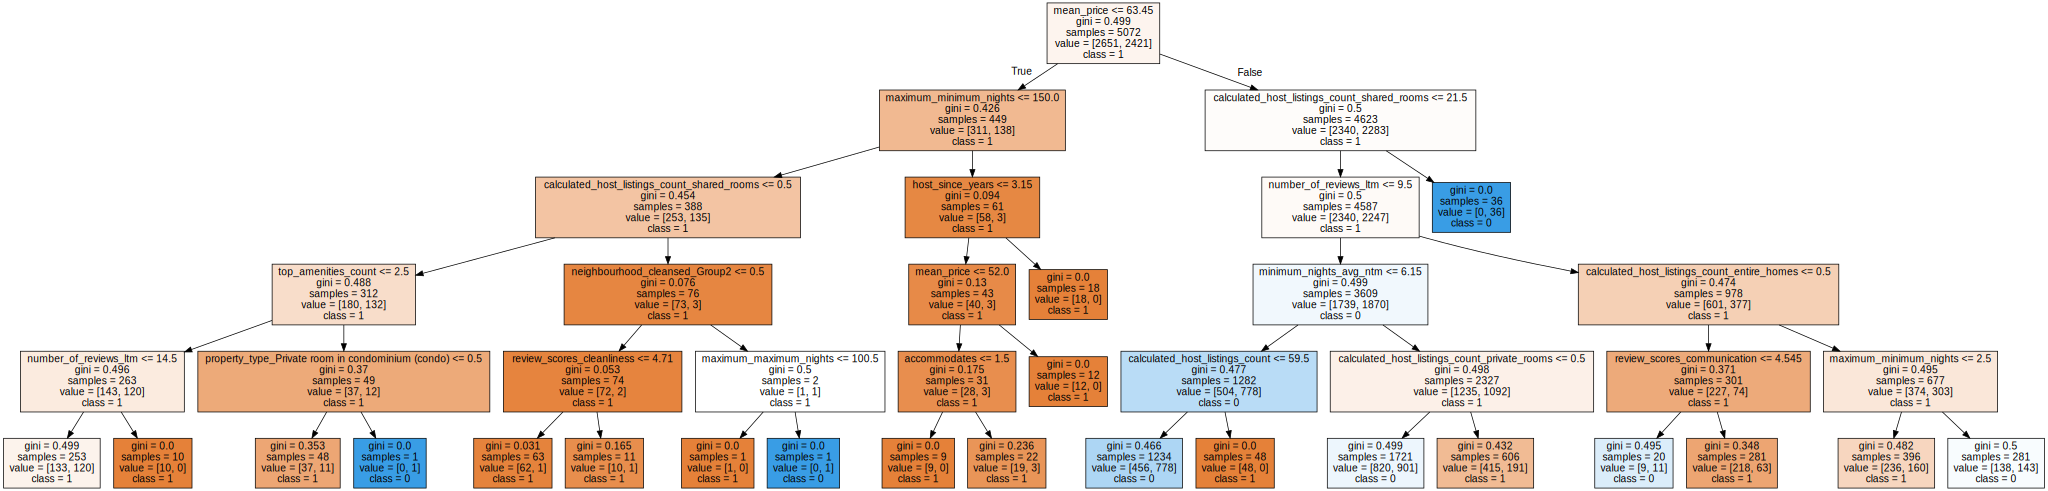

In [53]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(all_clf, out_file=None, 
                                feature_names=all_X.columns, 
                                class_names=all_y_str,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="pdf") 
graph.render("clf",format='pdf', view=False)
graph

Random Forest Model

In [54]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, max_features='auto',max_depth=5,random_state = 1)
# Train the model on training data
rf.fit(all_X, all_y)
#Predict the response for test dataset
all_y_pred = rf.predict(all_X_test)
# Model Accuracy
print("Random Forest Model Accuracy:",metrics.accuracy_score(all_y_test, all_y_pred))

Random Forest Model Accuracy: 0.7018927444794952


Confusion Matrix

In [55]:
print(confusion_matrix(all_y_test, all_y_pred))
print(classification_report(all_y_test, all_y_pred))

[[492 134]
 [244 398]]
              precision    recall  f1-score   support

           0       0.67      0.79      0.72       626
           1       0.75      0.62      0.68       642

    accuracy                           0.70      1268
   macro avg       0.71      0.70      0.70      1268
weighted avg       0.71      0.70      0.70      1268



Print out Tree Graph

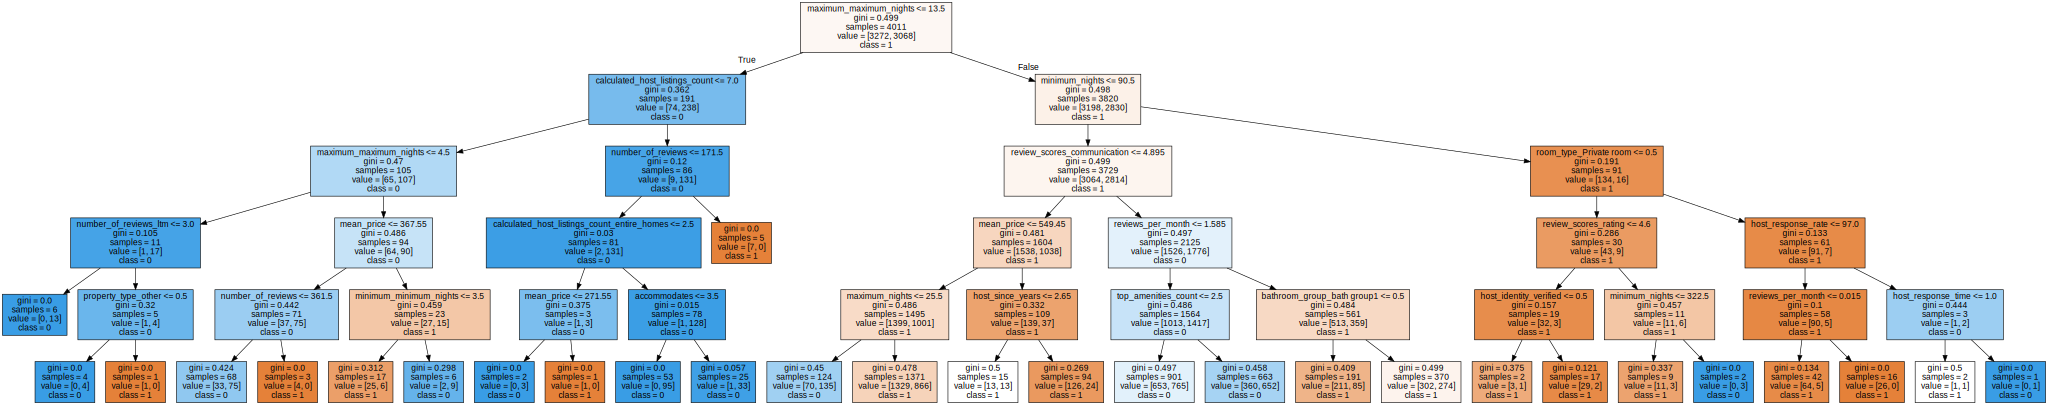

In [56]:
# Extract single tree
estimator = rf.estimators_[5]

# DOT data
dot_data = tree.export_graphviz(estimator, out_file=None, 
                                feature_names=all_X.columns,
                                class_names = all_y_str,  
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="pdf") 
graph.render("rf",format="pdf", view=False)
graph

Random Forest Model Deeper

In [57]:
# Instantiate model with 100 decision trees
rf2 = RandomForestClassifier(n_estimators = 1000, max_depth=10,random_state = 1)
# Train the model on training data
rf2.fit(all_X, all_y)
#Predict the response for test dataset
all_y_pred = rf2.predict(all_X_test)
# Model Accuracy
print("Random Forest Model Accuracy:",metrics.accuracy_score(all_y_test, all_y_pred))

Random Forest Model Accuracy: 0.8406940063091483


Confusion Matrix Train

In [58]:
#Predict the response for train dataset
all_y_pred_train = rf2.predict(all_X_train)
print(confusion_matrix(all_y_train, all_y_pred_train))
print(classification_report(all_y_train, all_y_pred_train))

[[2180  471]
 [ 344 2077]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      2651
           1       0.82      0.86      0.84      2421

    accuracy                           0.84      5072
   macro avg       0.84      0.84      0.84      5072
weighted avg       0.84      0.84      0.84      5072



Confusion Matrix Test

In [59]:
print(confusion_matrix(all_y_test, all_y_pred))
print(classification_report(all_y_test, all_y_pred))

[[530  96]
 [106 536]]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       626
           1       0.85      0.83      0.84       642

    accuracy                           0.84      1268
   macro avg       0.84      0.84      0.84      1268
weighted avg       0.84      0.84      0.84      1268



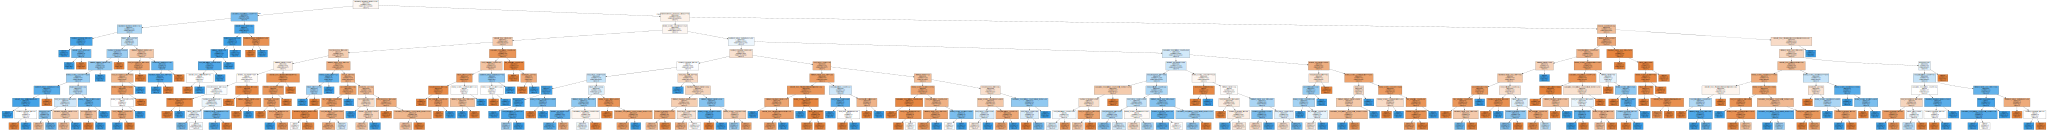

In [60]:
# Extract single tree
estimator = rf2.estimators_[5]

# DOT data
dot_data = tree.export_graphviz(estimator, out_file=None, 
                                feature_names=all_X.columns,
                                class_names = all_y_str,  
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="pdf") 
graph.render("rf2",format="pdf", view=False)
graph

Feature Importances 

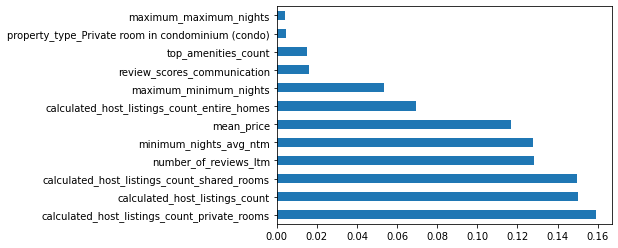

In [61]:
feat_importances = pd.Series(all_clf.feature_importances_, index=all_X_train.columns)
feat_importances.nlargest(12).plot(kind='barh')

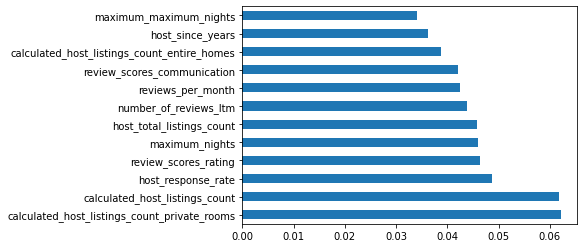

In [62]:
feat_importances = pd.Series(rf.feature_importances_, index=all_X_train.columns)
feat_importances.nlargest(12).plot(kind='barh')

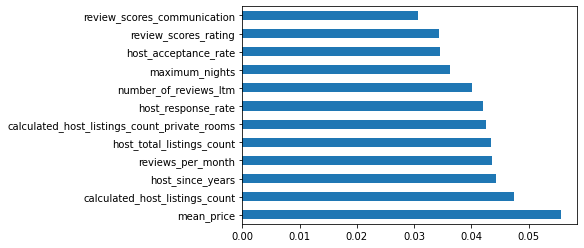

In [63]:
feat_importances = pd.Series(rf2.feature_importances_, index=all_X_train.columns)
feat_importances.nlargest(12).plot(kind='barh')

SHAP Feature Importance

In [64]:
explainer = shap.TreeExplainer(rf2)
shap_values = explainer.shap_values(all_X_test)

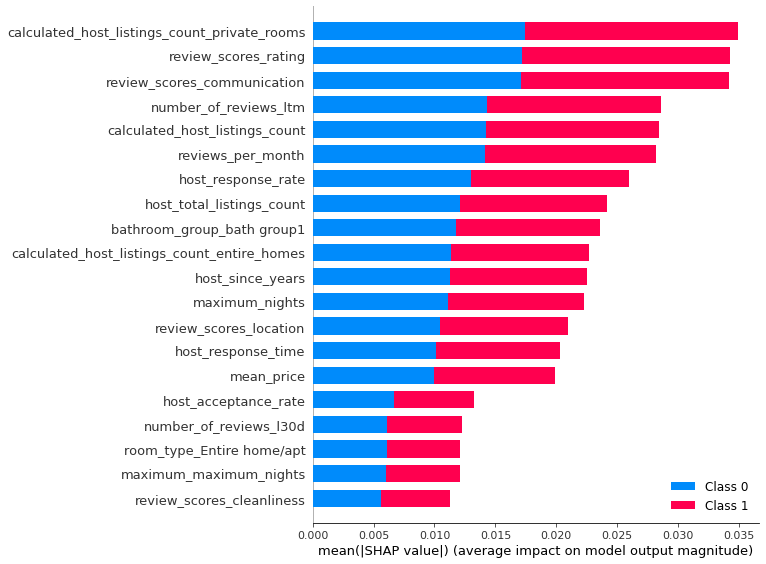

In [65]:
shap.summary_plot(shap_values, all_X_test)

In [66]:
# Get numerical feature importances for Decision tree Classifier Model 
importances = all_clf.feature_importances_
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(all_features, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: calculated_host_listings_count_private_rooms Importance: 0.16
Variable: calculated_host_listings_count Importance: 0.15
Variable: calculated_host_listings_count_shared_rooms Importance: 0.15
Variable: minimum_nights_avg_ntm Importance: 0.13
Variable: number_of_reviews_ltm Importance: 0.13
Variable: Success_rate         Importance: 0.12
Variable: calculated_host_listings_count_entire_homes Importance: 0.07
Variable: maximum_minimum_nights Importance: 0.05
Variable: review_scores_communication Importance: 0.02
Variable: licensed             Importance: 0.02
Variable: host_response_time   Importance: 0.0
Variable: host_response_rate   Importance: 0.0
Variable: host_acceptance_rate Importance: 0.0
Variable: host_is_superhost    Importance: 0.0
Variable: host_total_listings_count Importance: 0.0
Variable: host_has_profile_pic Importance: 0.0
Variable: host_identity_verified Importance: 0.0
Variable: accommodates         Importance: 0.0
Variable: beds                 Importance: 0.

In [67]:
# Get numerical feature importances for Random Forest Model 
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(all_features, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: calculated_host_listings_count Importance: 0.06
Variable: calculated_host_listings_count_private_rooms Importance: 0.06
Variable: host_response_rate   Importance: 0.05
Variable: host_total_listings_count Importance: 0.05
Variable: maximum_nights       Importance: 0.05
Variable: review_scores_rating Importance: 0.05
Variable: number_of_reviews_ltm Importance: 0.04
Variable: review_scores_communication Importance: 0.04
Variable: calculated_host_listings_count_entire_homes Importance: 0.04
Variable: reviews_per_month    Importance: 0.04
Variable: host_since_years     Importance: 0.04
Variable: minimum_maximum_nights Importance: 0.03
Variable: maximum_maximum_nights Importance: 0.03
Variable: maximum_nights_avg_ntm Importance: 0.03
Variable: review_scores_location Importance: 0.03
Variable: Success_rate         Importance: 0.03
Variable: room_type_Shared room Importance: 0.03
Variable: host_response_time   Importance: 0.02
Variable: host_acceptance_rate Importance: 0.02
Variable:

Prediction 

In [68]:
prediction_data_set = all_X_test.head(4)
prediction_data_set


,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,accommodates,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_years,mean_price,host_in_sfo,licensed,top_amenities_count,host_verification_count,neighbourhood_cleansed_Group1,neighbourhood_cleansed_Group2,property_type_Entire condominium (condo),property_type_Entire guest suite,property_type_Entire loft,property_type_Entire rental unit,property_type_Entire residential home,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Private room in condominium (condo),property_type_Private room in guest suite,property_type_Private room in rental unit,property_type_Private room in residential home,property_type_Room in aparthotel,property_type_Room in boutique hotel,property_type_Room in hotel,property_type_Shared room in hostel,property_type_other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bathroom_group_bath group1,bathroom_group_bath group2,bathroom_group_bath group3,bathroom_group_bath group4,bathroom_group_bath group5,bedrooms_1.0,bedrooms_2.0,bedrooms_3.0,bedrooms_More than 3
607,3,27,17,0,6.0,1,1,2,1.0,30,365,30.0,30.0,365.0,365.0,30.0,365.0,18,1,0,4.27,4.19,4.63,4.44,4.69,0,4,4,0,0,0.19,12.3,100.0,1.0,0.0,2,4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
1812,0,100,75,1,1.0,1,1,6,3.0,3,75,3.0,3.0,75.0,75.0,3.0,75.0,60,12,2,4.95,4.95,4.93,4.97,4.75,0,1,1,0,0,0.97,10.7,336.6,1.0,0.0,2,8,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
354,1,94,84,0,1.0,1,1,4,2.0,180,180,180.0,180.0,180.0,180.0,180.0,180.0,1,0,0,5.00,5.00,5.00,5.00,5.00,0,1,1,0,0,0.01,9.9,185.0,0.0,0.0,2,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
1620,0,100,100,1,141.0,1,1,2,1.0,2,7,2.0,2.0,7.0,7.0,2.0,7.0,64,0,0,4.73,4.84,4.91,4.91,4.91,1,57,57,0,0,1.03,5.7,95.0,0.0,0.0,2,8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


In [69]:
prediction_data_set_actual = all_y_test.head(4)
prediction_data_set_actual

607     0
1812    1
354     0
1620    1
Name: Success, dtype: int64

In [70]:
#Predict with 
all_y_pred = rf2.predict(prediction_data_set)
all_y_pred                   

array([0, 1, 0, 1])